# This notebook describes the codes to plot the stretching data with estimatio of the modulus as well as cyclic data with cycles upto a uplied strain in increasing order of magnitude to look at strain rate dependence, plasticity and the elastic energy contribution to the total work done. The example is a csv file containing the cyclic loading data for RTV 615 an elastomer

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import math
from scipy.integrate import trapz
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

%matplotlib inline

C:\Users\AKASHS~1\AppData\Local\Temp/ipykernel_17376/4207210623.py:8: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


## Loading the csv as panda dataframe

In [4]:
df = pd.read_csv(r"D:\ESPCI\Experiments\ingstron\ECOFLEX\20240523_111311.is_tcyclic_Exports\20240523_111311_1_1.csv",skiprows = 14, encoding='latin-1')

In [5]:
df

,Time (s),Displacement (mm),Shifted displacement 10.89 (mm),Force (N),Strain AS (%),Stress AS (kPa),Nombre total de cycles,Nombre de cycles,Extenso strain (%),Unnamed: 9
0,0.000,11.9873,22.8773,0.0000,-463.7887,0.0052,0.0,0.0,0.0001,NaN
1,0.020,11.9873,22.8773,0.0003,-463.7883,0.0685,0.0,0.0,0.0028,NaN
2,0.040,11.9874,22.8774,0.0001,-463.7862,0.0253,0.0,0.0,0.0049,NaN
3,0.060,11.9875,22.8775,-0.0009,-463.7840,-0.2159,0.0,0.0,0.0054,NaN
4,0.080,11.9876,22.8776,-0.0009,-463.7816,-0.2209,0.0,0.0,0.0054,NaN
...,...,...,...,...,...,...,...,...,...,...
45718,912.828,36.7423,47.6323,1.0749,55.1840,268.7197,16.0,1.0,54.8967,NaN
45719,912.833,36.7624,47.6524,0.7888,55.6055,197.2089,16.0,1.0,54.3960,NaN
45720,912.838,36.7825,47.6725,0.5349,56.0282,133.7218,16.0,1.0,53.9759,NaN
45721,912.845,36.8069,47.6969,0.2509,56.5382,62.7340,16.0,1.0,53.5295,NaN


## The above dataframe contains column and we can pick the data from specific column to manipulate or plot as below

<AxesSubplot:xlabel='Time (s)'>

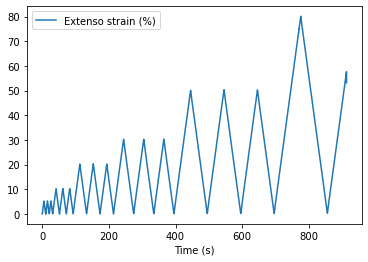

In [7]:
df.plot(x='Time (s)', y='Extenso strain (%)')

## Plotting the data as stress strain. For multiple plots, I have converted to an iteration over different files. For multiple files, do not forget to append the array of the parameter describing the property of the sample (thickness,width etc)

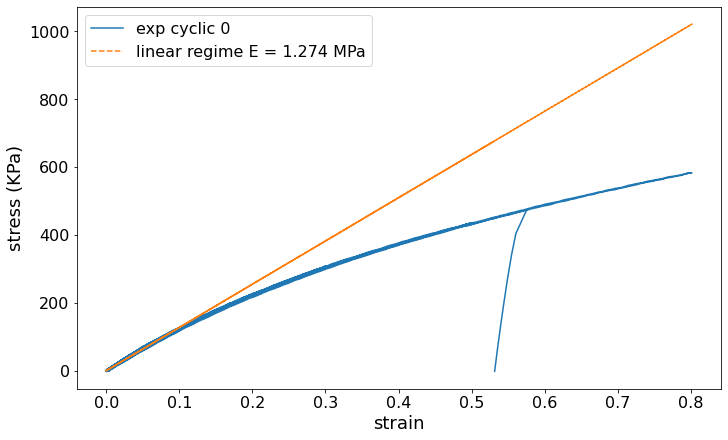

<Figure size 432x288 with 0 Axes>

In [4]:
fig, axs = plt.subplots(1,1, figsize =(10,6), constrained_layout= True)
df = []
#Initial_position = [47.36,47.36, 47.32] #mm
#length = [3,3,3] # cm
t = np.array([1]) # thickness of the sample in mm
b= np.array([4])  #width of the sample in mm
files = [r"D:\ESPCI\espci_scripts\Thin_films\20240523_111311_1_1.csv"] #The csv file from instron

# Process each file
for i in range(len(files)):
    # Read the CSV file
    df.append(pd.read_csv(files[i], skiprows=14, encoding='latin-1'))
    df1 = df[i]
    
    # Calculate strain and stress
    strain = np.array(df1['Extenso strain (%)']) * 1e-2  # convert to fraction
    stress = np.array(df1['Force (N)']) / (t * b * 1e-6)  # convert to Pa
    
    # Define linear function for fitting
    func = lambda x, p: p * x
    
    # Limit for fitting
    lim = 0.1
    
    # Fit the linear part of the data
    param, err = curve_fit(func, strain[(strain < lim)], stress[(strain < lim)])
    
    # Plot experimental data
    axs.plot(strain, stress * 1e-3, label='exp cyclic {}'.format(i))
    
# Plot the fitted line
axs.plot(strain, strain * param[0] * 1e-3, linestyle='--', label='linear regime E = {} MPa'.format(round(param[0] * 1e-6, 3)))

# Customize plot
axs.set_ylabel('stress (KPa)', fontsize=18)
axs.set_xlabel('strain', fontsize=18)
axs.tick_params(axis="x", labelsize=16)
axs.tick_params(axis="y", labelsize=16)
axs.legend(fontsize=16)

# Show plot
plt.show()

# Optionally save the plot
plt.savefig('20221208_stress_strain_ingstron_RTV_figure_1.png')

## Here I plot the data in different color for different cycle. The experiment here is stretching to a set strain $\gamma_{set}$ at a constant $\dot{\gamma}$ and relaxing to 0 stress. I repeat this step continuously 3 times at each $\gamma_{set}$. Later, I keep the stress at 0 for t s (here 0 s) and then go to to a new $\gamma_{set}$. The $\gamma_{set}$ in this case are [0.05,0.05,0.05,0.1,0.1,0.1,0.3,0.3,0.3,0.5,0.5,0.5,0.8,0.8] 

- I also calculate the area under the curve for each stretching and relaxation to estimate the the contribution of elastic energy in the total work done in stretching

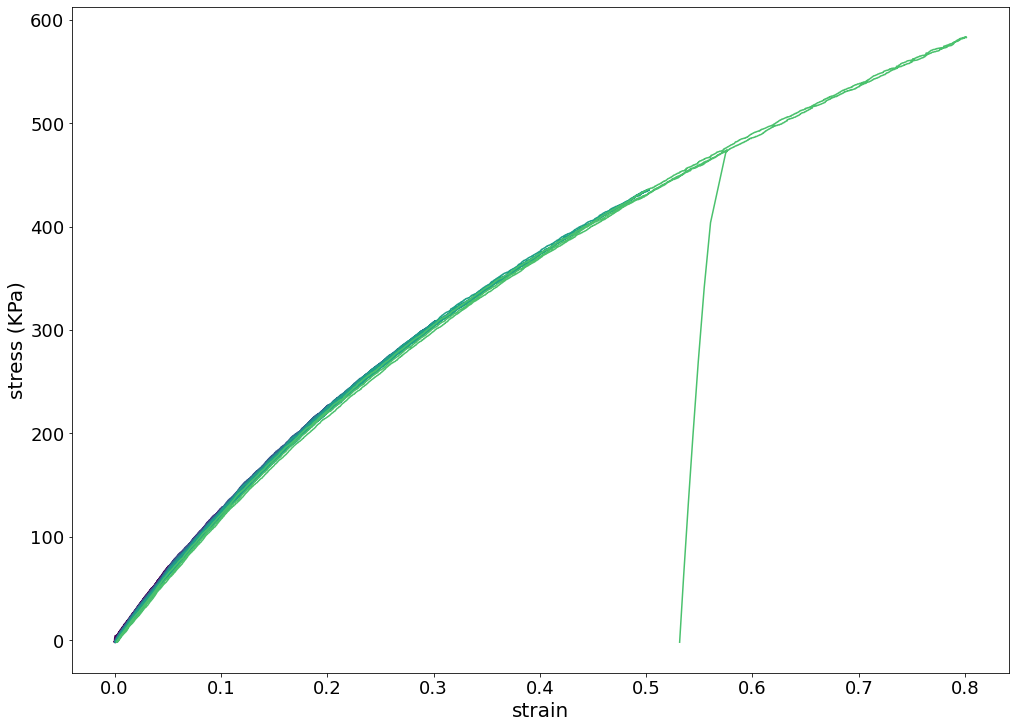

In [10]:
import matplotlib.pylab as pl
fig, axs = plt.subplots(1,1, figsize =(14,10), constrained_layout= True)

df = []
length = [2]  # cm (though not used in this snippet)
t = 1  # mm (thickness)
b = 4  # mm (width)
n = 8  # Number of color segments for cycling
total_cycles = 28  # Total number of cycles including stretching, relaxing and 

colors = np.array([pl.cm.viridis(np.linspace(0,1,n)),pl.cm.Reds(np.linspace(0,1,n))])
labels = ['sample 1 t = 1 mm, 1 %$s^{-1}$']
files = [r"D:\ESPCI\Experiments\ingstron\ECOFLEX\20240523_111311.is_tcyclic_Exports\20240523_111311_1_1.csv"]
area_under_curve = np.zeros((len(files), total_cycles))

for i in range(len(files)):
    df.append(pd.read_csv(files[i],skiprows = 14, encoding='latin-1'))
    df1 = df[i]
    strain = np.array(df1['Extenso strain (%)'])*1e-2 # convert to fraction
    stress = np.array(df1['Force (N)'])/(t*b*1e-6)  # convert to Pa
    cycles = np.array(df1['Nombre total de cycles'])

    for j in range (n):
        axs.plot(strain[(cycles>=(j)*3) & (cycles<(j+1)*3)], stress[(cycles>=(j)*3) & (cycles<(j+1)*3)]*1e-3, color=colors[i,j], label = 
                labels[i])
axs.set_ylabel('stress (KPa)', fontsize =20)
axs.set_xlabel('strain', fontsize = 20)
axs.tick_params(axis="x", labelsize=18)
axs.tick_params(axis="y", labelsize=18)

# Calculate Area Under the Curve:

for i in range(len(files)):
    for j in  range(total_cycles):
        df.append(pd.read_csv(files[i],skiprows = 4, encoding='latin-1'))
        df1 = df[i]
        strain = np.array(df1['Strain AS (%)'])*1e-2
    
        stress = np.array(df1['Stress AS (kPa)'])
        cycles = np.array(df1['Nombre total de cycles'])
        area = trapz(stress[(cycles == (j+1)/2-0.5)],x = strain[(cycles == (j+1)/2-0.5)])
        area_under_curve[i,j] = area
        
    
#plt.savefig('20221208_stress_strain_ingstron_RTV_figure_2.png')

### The total work done calculated from the area under the strecthing upto $\gamma_{set}$

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

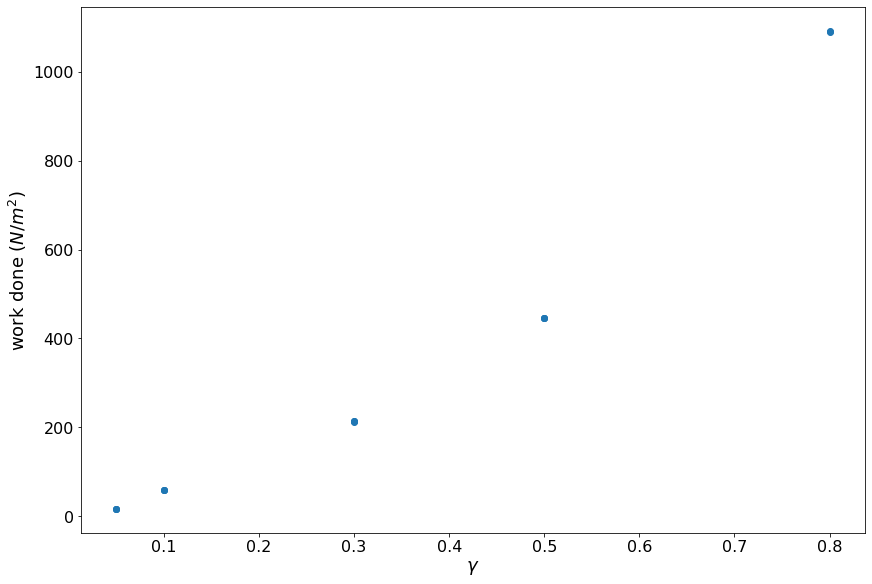

In [14]:
plt.figure(figsize = (12,8), constrained_layout= True)
strain_set = np.array([0.05,0.05,0.05,0.1,0.1,0.1,0.3,0.3,0.3,0.5,0.5,0.5,0.8,0.8])
plt.scatter(strain_set, area_under_curve[0,::2])
#plt.scatter(strain, area_under_curve[1,::2])
plt.xlabel('$\gamma$', fontsize = 18) 
plt.ylabel('work done $(N/m^2)$', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)


### The elastic contribution calculated from the relaxation curve. Since, the material is perfectly elastic, it is similar to the work done calculated in previous graph

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

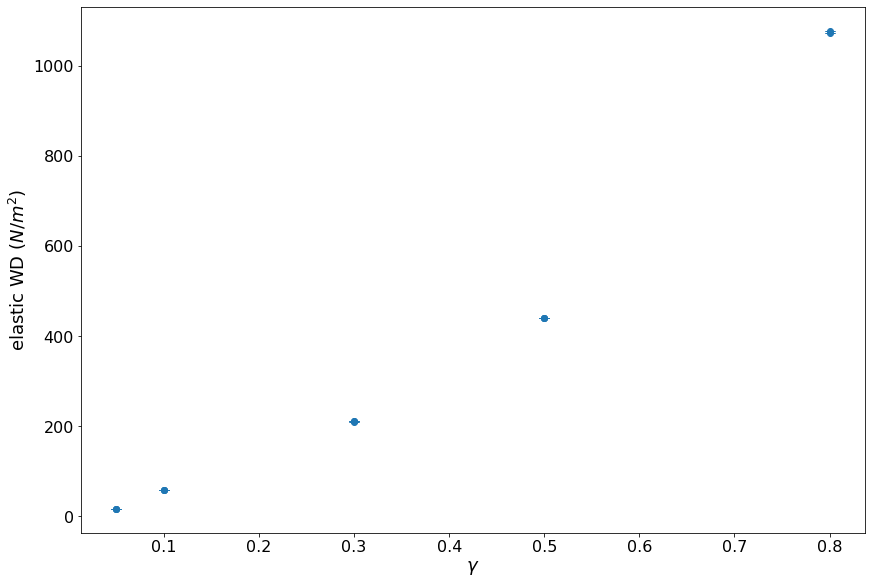

In [16]:
plt.figure(figsize = (12,8),constrained_layout= True)
strain = np.array([0.05,0.05,0.05,0.1,0.1,0.1,0.3,0.3,0.3,0.5,0.5,0.5,0.8,0.8])
#plt.scatter(strain, area_under_curve[0,::2])
#plt.scatter(strain, area_under_curve[1,::2])
yavg = np.mean(area_under_curve[:,1::2], axis = 0)
yerr = np.std(area_under_curve[:,1::2], axis = 0)
plt.errorbar(strain, np.abs(yavg) , yerr=yerr, fmt='o', capsize=5)
plt.xlabel('$\gamma$', fontsize = 18) 
plt.ylabel('elastic WD $(N/m^2)$', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.savefig("total_EE_Stodv1_cyclic_1.png")